In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2, f, norm

In [2]:
df = pd.read_csv("Churn_Modelling.csv")

# Data Cleaning & Exploration

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

No missing values

In [5]:
df.duplicated().sum()

0

No duplicate rows

## Dropping unused variables

Variables unused in our analysis:
- RowNumber
- CustomerId
- Surname
- NumOfProducts

In [6]:
unused_columns = ["RowNumber", "CustomerId", "Surname", "NumOfProducts"]
df.drop(columns=unused_columns, inplace = True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,1,0,113931.57,1
3,699,France,Female,39,1,0.00,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,79084.10,0


In [7]:
df.shape

(10000, 10)

10,000 observations in the sample, data for 11 different variables

Our main variable of interest is **Exited**: Label indicating whether or not a customer has churned from the bank

# Descriptive Statistics

In [8]:
df_churned = df[df['Exited']==1]
df_retained = df[df['Exited']==0]

## Continuous Variables
- Credit Score
- Age
- Balance
- Estimated Salary

In [9]:
continuous_variables = ["CreditScore", "Age", "Balance", "EstimatedSalary"]
summary_cont = df[continuous_variables].describe()
summary_cont = summary_cont.loc[["mean", "std", "min", "50%", "max"]].rename(index={"50%": "median", "min":"minimum", "max":"maximum"})
summary_cont

,CreditScore,Age,Balance,EstimatedSalary
mean,650.528800,38.921800,76485.889288,100090.239881
std,96.653299,10.487806,62397.405202,57510.492818
minimum,350.000000,18.000000,0.000000,11.580000
median,652.000000,37.000000,97198.540000,100193.915000
maximum,850.000000,92.000000,250898.090000,199992.480000


In [10]:
print("Mean observations for continuous variables:") 
print(df.describe().loc['mean',continuous_variables])
print("\n")
print("Median observations for continuous variables:")
print(df.describe().loc['50%',continuous_variables])

Mean observations for continuous variables:
CreditScore           650.528800
Age                    38.921800
Balance             76485.889288
EstimatedSalary    100090.239881
Name: mean, dtype: float64


Median observations for continuous variables:
CreditScore           652.000
Age                    37.000
Balance             97198.540
EstimatedSalary    100193.915
Name: 50%, dtype: float64


*For money-related data (Balance & EstimatedSalary), we can assume that the currency is *euros*, since the three geographical regions of the bank customers in this sample are France, Germany, and Spain, and no currency is specified in the description for the dataset*

In [11]:
for variable in continuous_variables:
    print(f"LQ and UQ for {variable} are: ", df.describe().loc["25%",variable], " and ", df.describe().loc["75%",variable])

LQ and UQ for CreditScore are:  584.0  and  718.0
LQ and UQ for Age are:  32.0  and  44.0
LQ and UQ for Balance are:  0.0  and  127644.24
LQ and UQ for EstimatedSalary are:  51002.11  and  149388.2475


In [12]:
print("Standard deviations for continuous variables:")
print(df.describe().loc['std',continuous_variables])

Standard deviations for continuous variables:
CreditScore           96.653299
Age                   10.487806
Balance            62397.405202
EstimatedSalary    57510.492818
Name: std, dtype: float64


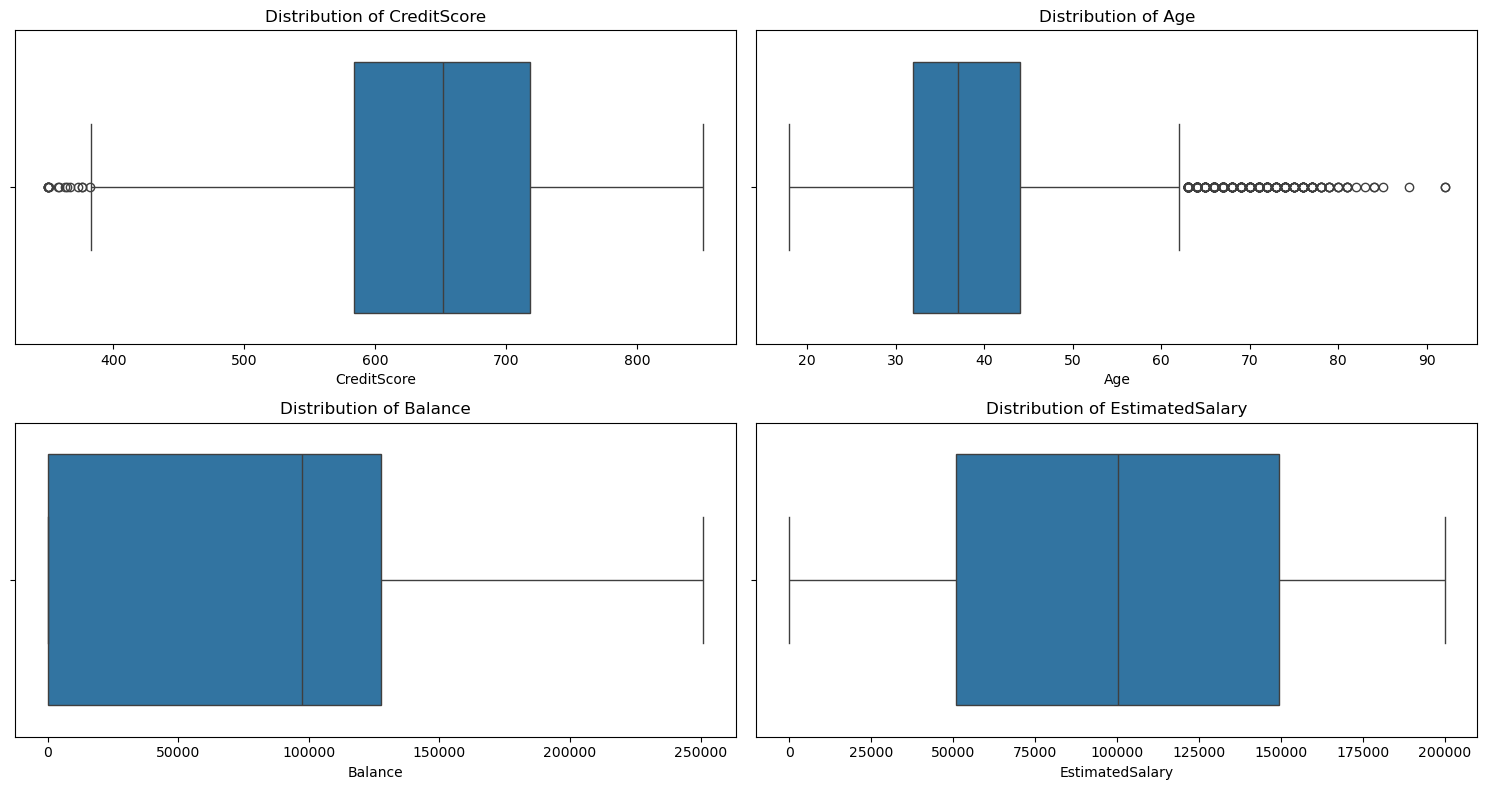

In [13]:
fig, axes = plt.subplots(2,2,figsize=(15,8))
axes = axes.flatten()

for i, variable in enumerate(continuous_variables):
    sns.boxplot(x=variable, data=df, ax=axes[i])
    title = f"Distribution of {variable}" 
    axes[i].set_title(title)

plt.tight_layout()
plt.show()

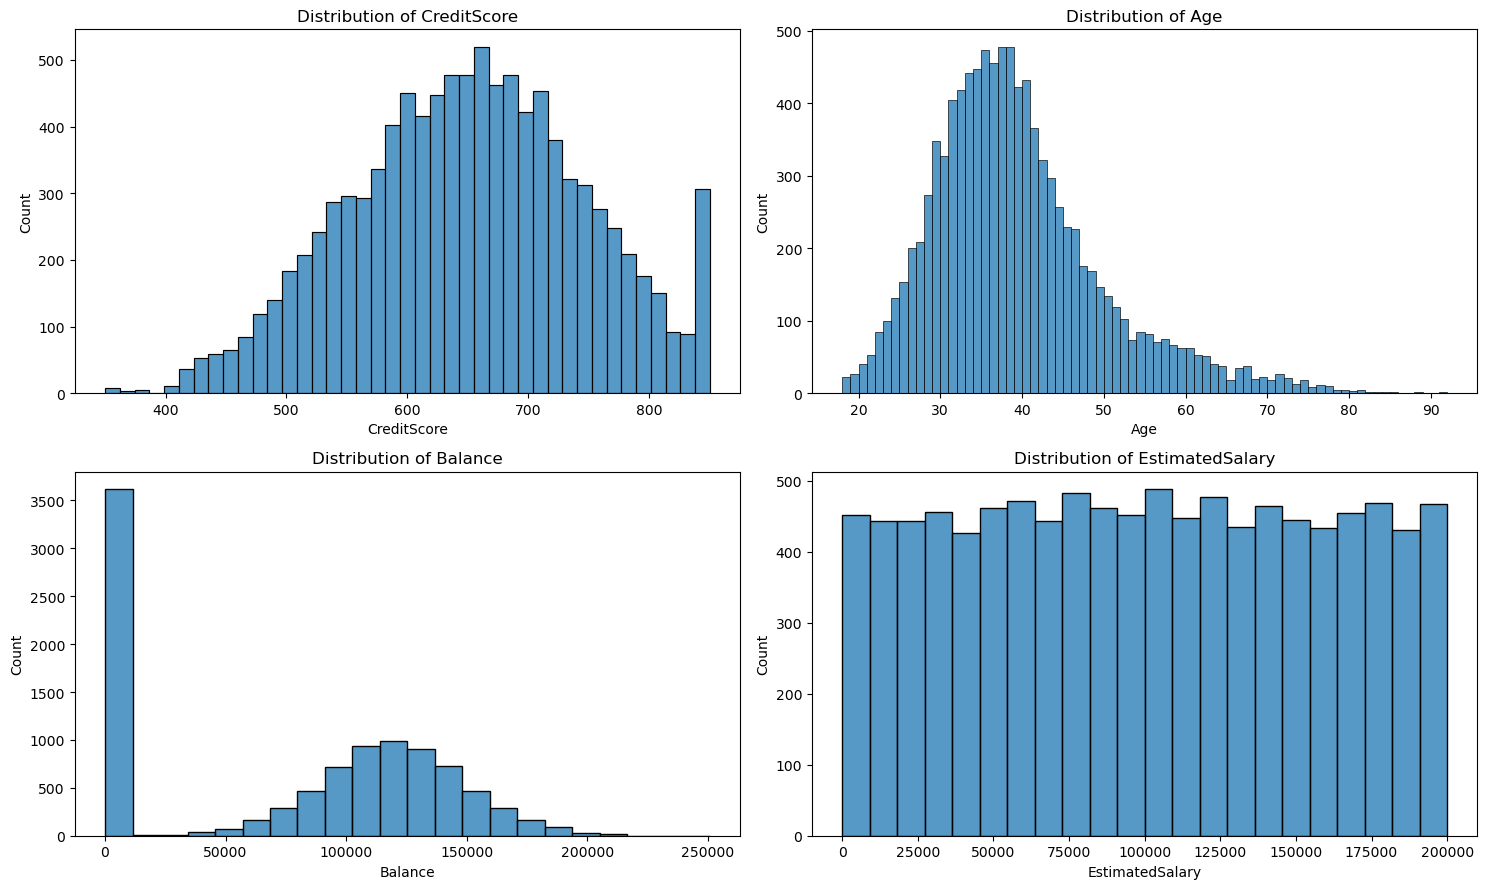

In [14]:
fig, axes = plt.subplots(2,2,figsize=(15,9))
axes = axes.flatten()

hist_variables = ["CreditScore", "Age", "Balance", "EstimatedSalary"]

for i, variable in enumerate(hist_variables):
    if variable == "Age":
        sns.histplot(x=variable, data=df, ax=axes[i], bins = 92-18)
        title = f"Distribution of {variable}" 
        axes[i].set_title(title)
    else:
        sns.histplot(x=variable, data=df, ax=axes[i])
        title = f"Distribution of {variable}" 
        axes[i].set_title(title)

plt.tight_layout()
plt.show()

**Comments**:
- *Credit Score*: appears to approximately normally distributed, although there are several customers who appear to have achieved the max credit score (850) explaining why there is a tall bar right at the end
- *Age*: Right-skewed with many older customers, although not large in quantity, compared to the median: 37 years old
- *Balance*: Appears normally distributed but a huge number of accounts with a balance of 0 has affected the shape of the graph (another visualization without these empty accounts is shown below)
- *Estimated Salary*: Appears approximately uniformly distributed from €11.58 (minimum) to €199,992.48 (maximum)

In [15]:
print("Number of Customers with a 850 credit score: ", df[df['CreditScore'] > 849].shape[0])

Number of Customers with a 850 credit score:  233


Text(0.5, 1.0, 'Balance Distribution Without Empty Accounts')

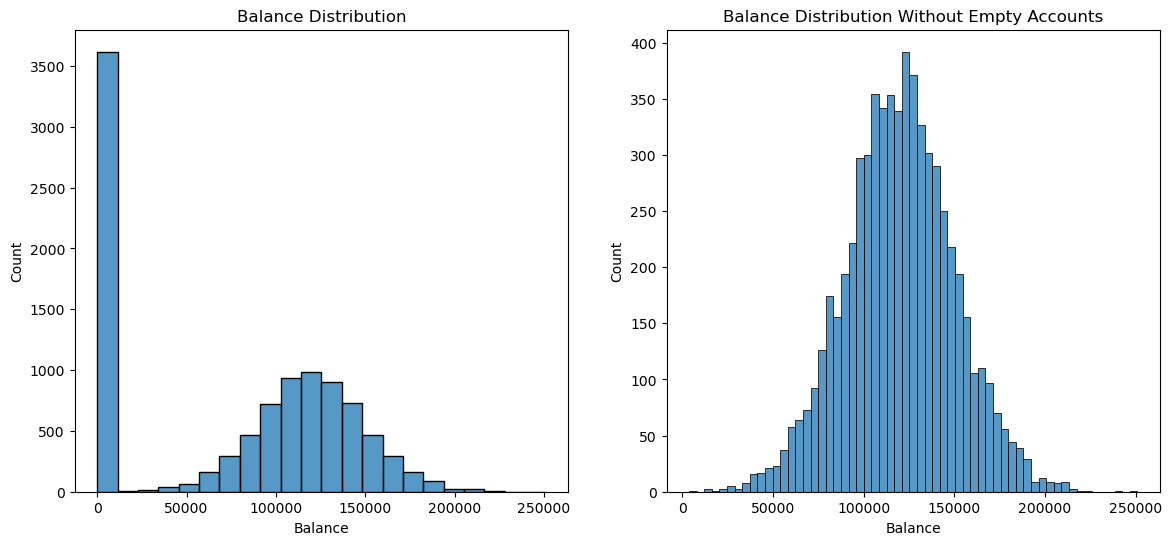

In [16]:
fig, axes = plt.subplots(1,2,figsize=(14,6))
axes = axes.flatten()

sns.histplot(x='Balance', data=df, ax=axes[0])
title = f"Balance Distribution" 
axes[0].set_title(title)

sns.histplot(x='Balance', data=df[df["Balance"] > 0], ax=axes[1])
title = f"Balance Distribution Without Empty Accounts" 
axes[1].set_title(title)

## Categorical Variables
- Geography
- Gender
- Tenure
- 'Has Credit Card'
- 'Is Active Member'
- Exited (Churned)

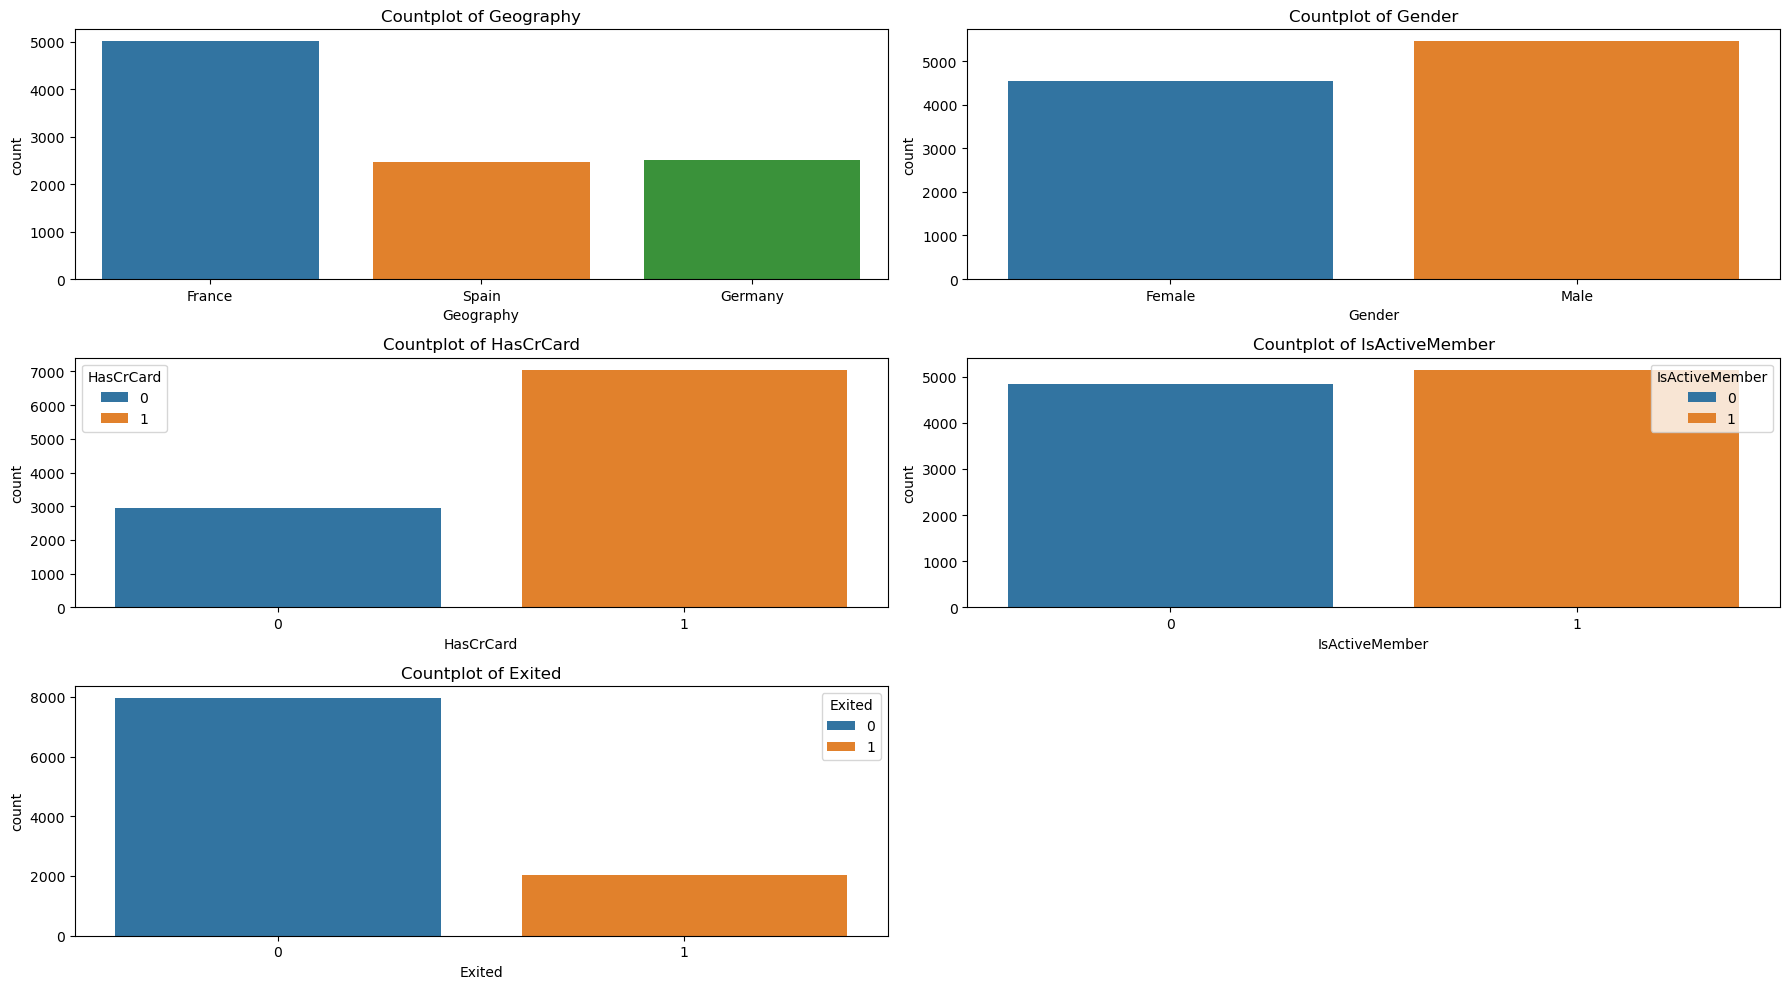

In [17]:
fig, axes = plt.subplots(3,2,figsize=(18,10))
axes = axes.flatten()

categorical_variables = ["Geography", "Gender", "HasCrCard", "IsActiveMember", "Exited"]
for i, variable in enumerate(categorical_variables):
    sns.countplot(x=variable, data=df, hue=variable, ax=axes[i])
    title = f"Countplot of {variable}" 
    axes[i].set_title(title)

axes[5].axis("off")
plt.tight_layout()
plt.show()

**Comments**:
- *Geography:* Around half of the customers in the sample are based in France, and the remaining customers are almost evenly split between Spain and Germany
- *Gender:* The Female/Male split in the sample is approximately 45/55 (i.e. there are around 1000 more Males than Females)
- *Tenure:* The number of years customers stay with the bank is very variable (distribution seems uniform, with the exception of few people staying for either <1 year or 10+ years)
- *Number of Products:* The vast majority of customers in this sample have either 1 or 2 products with the bank (very few have 3 or 4)
- *'Has a Credit Card':* The majoriy (~70%) of customers have a credit card with the bank, and the remaining customers do not
- *'Is an Active Member':* The sample contains an almost equal amount of active/inactive members
- *Exited:* As previously mentioned,, the churn rate in the sample is ~20%

### Plots by churn status

In [18]:
def mean_stats(df, label):
    return {
        "Group": label,
        "Mean Age": df["Age"].mean(),
        "Mean Credit Score": df["CreditScore"].mean(),
        "Mean Balance": df["Balance"].mean(),
        "Mean Estimated Salary": df["EstimatedSalary"].mean(),
    }

# Means for each customer group
stats_all = mean_stats(df, "All Customers")
stats_churned = mean_stats(df_churned, "Churned Customers")
stats_retained = mean_stats(df_retained, "Retained Customers")

summary_df = pd.DataFrame([stats_all, stats_churned, stats_retained])
summary_df

,Group,Mean Age,Mean Credit Score,Mean Balance,Mean Estimated Salary
0,All Customers,38.921800,650.528800,76485.889288,100090.239881
1,Churned Customers,44.837997,645.351497,91108.539337,101465.677531
2,Retained Customers,37.408389,651.853196,72745.296779,99738.391772


Some insights may be drawn from comparing mean values:

- Churners are about 7 years older than retained customers by comparing the means (this will be verified later using confidence intervals)
- Churners have a significantly higher average balance (~ +€20,000) than non-churners
- Little to no variation between Credit Score and Estimated Salary in the two groups (both groups close to the true average)

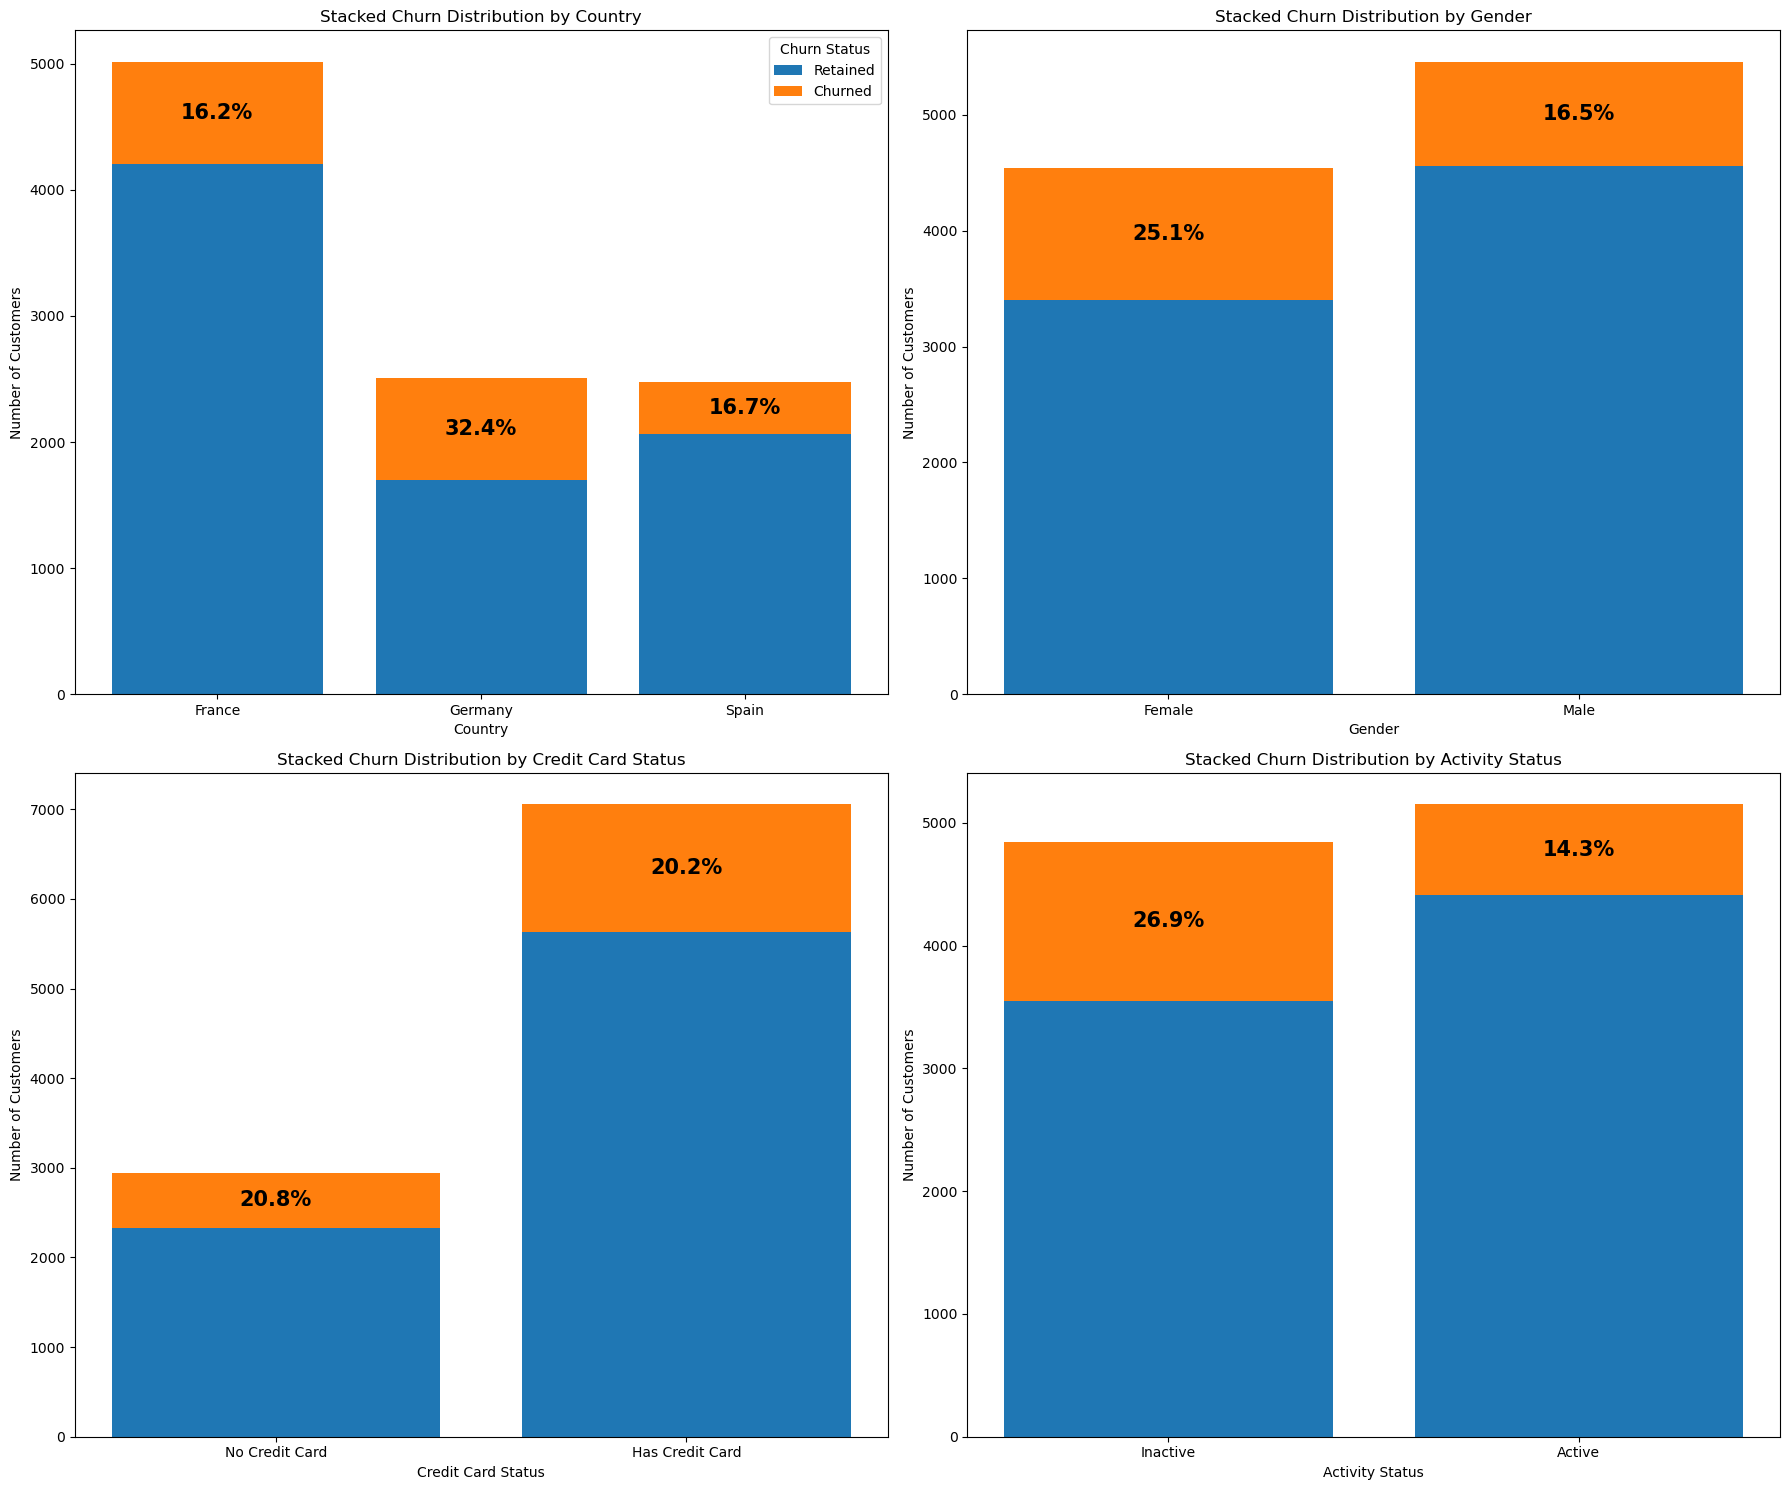

In [19]:
palette = {0: '#1f77b4', 1: '#ff7f0e'}
categorical_vars = ["Geography", "Gender", "HasCrCard", "IsActiveMember"]
var_labels = {
    "Geography": "Country",
    "Gender": "Gender",
    "Tenure": "Tenure (Years)",
    "HasCrCard": "Credit Card Status",
    "IsActiveMember": "Activity Status"
}
xtick_map = {
    "HasCrCard": {0: "No Credit Card", 1: "Has Credit Card"},
    "IsActiveMember": {0: "Inactive", 1: "Active"}
}

# Create figure and axes
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    ax = axes[i]
    
    # Group data
    churn_counts = df.groupby([var, "Exited"]).size().unstack().fillna(0)
    churn_counts.columns = ['Retained', 'Churned']
    churn_counts = churn_counts.sort_index()

    # Stacked bars
    ax.bar(churn_counts.index, churn_counts['Retained'], label='Retained', color=palette[0])
    ax.bar(churn_counts.index, churn_counts['Churned'], bottom=churn_counts['Retained'], label='Churned', color=palette[1])

    # Axis titles
    ax.set_title(f"Stacked Churn Distribution by {var_labels.get(var, var)}")
    ax.set_xlabel(var_labels.get(var, var))
    ax.set_ylabel("Number of Customers")

    # Tick labels
    if var in xtick_map:
        ax.set_xticks(range(len(churn_counts.index)))
        ax.set_xticklabels([xtick_map[var].get(val, str(val)) for val in churn_counts.index])

    # Annotate with churn percentages
    churn_percent = churn_counts['Churned'] / churn_counts.sum(axis=1) * 100
    for j, idx in enumerate(churn_counts.index):
        retained = churn_counts.loc[idx, 'Retained']
        churned = churn_counts.loc[idx, 'Churned']
        pct = churn_percent[idx]
        ax.text(
            j, retained + churned / 2, f"{pct:.1f}%",
            ha='center', va='center', color='black', fontsize=15, fontweight='bold'
        )

# Turn off any unused subplots
if len(categorical_vars) < len(axes):
    for j in range(len(categorical_vars), len(axes)):
        axes[j].axis("off")

# Add legend once
axes[0].legend(title="Churn Status")

plt.tight_layout()
plt.show()

# Research Objectives

## 1. Customer Profiling
> **What does the average bank customer look like?**

In [20]:
summary_means = df.describe().iloc[1,]
print(summary_means)

CreditScore           650.528800
Age                    38.921800
Tenure                  5.012800
Balance             76485.889288
HasCrCard               0.705500
IsActiveMember          0.515100
EstimatedSalary    100090.239881
Exited                  0.203700
Name: mean, dtype: float64


In [21]:
print("Number of churners: ", df_churned.shape[0])
print("Number of non-churners: ", df_retained.shape[0])

Number of churners:  2037
Number of non-churners:  7963


The churn rate in this sample is 20.37%

### Parameter of Interest #1: Mean Age
> **A good point estimator: Sample Mean Age**
>
> Why it is a good estimator: *The sample mean is both **unbiased** and **consistent***

In [22]:
#calculating sample mean
sample_mean_age = df.describe().loc['mean','Age']
print("Sample mean Age:", sample_mean_age)

Sample mean Age: 38.9218


#### 95% confidence level:

In [23]:
from scipy.stats import norm, chi2

z_value = norm.ppf(0.975)
n = 10000

#calculating the sample variance:
sample_std_age = df.describe().loc['std','Age']
sample_variance_age = sample_std_age ** 2
print("Sample Variance of the Ages:", sample_variance_age, f"(Standard Deviation is: {sample_std_age})")

#calculating 95% confidence interval
# (Sample Mean) ± Z_0.025(sqrt(s^2 / n))
LL = sample_mean_age - (z_value * np.sqrt(sample_variance_age / n))
UL = sample_mean_age + (z_value * np.sqrt(sample_variance_age / n))
print("95% CI for the mean age: [", LL, ",", UL, "]")

Sample Variance of the Ages: 109.99408416841645 (Standard Deviation is: 10.487806451704591)
95% CI for the mean age: [ 38.71624277077832 , 39.12735722922167 ]


We are 95% confident that the true average age of all bank customers of this bank lies between 38.71 and 39.13 years old (For simplicitly, we can say that the true average age is very likely 39 years old).

### Difference between Mean Age of Churners/Non-Churners: 
> **A good point estimator: Difference between sample mean ages**
>
> Why it is a good estimator: *This difference is both **unbiased** and **consistent***

In [24]:
sample_mean_age_churners = df_churned.describe().loc['mean','Age']
sample_mean_age_non_churners = df_retained.describe().loc['mean','Age']

print("Sample age of churners: ", sample_mean_age_churners)
print("Sample age of non-churners: ", sample_mean_age_non_churners)
print("Point Estimator:")
sample_mean_difference = sample_mean_age_churners - sample_mean_age_non_churners
print("Difference between ages of churners and non-churners: ", sample_mean_difference)

Sample age of churners:  44.8379970544919
Sample age of non-churners:  37.40838879819164
Point Estimator:
Difference between ages of churners and non-churners:  7.429608256300263


#### 95% confidence interval

In [25]:
n_churners = 2037
n_non_churners = 7963

#calculating the sample variances for both groups:

sample_std_age_churners = df_churned.describe().loc['std','Age']
sample_variance_age_churners = sample_std_age_churners ** 2
print("Sample Variance of the churners' Ages:", sample_variance_age_churners, f"(Standard Deviation is: {sample_std_age_churners})")

sample_std_age_non_churners = df_retained.describe().loc['std','Age']
sample_variance_age_non_churners = sample_std_age_non_churners ** 2
print("Sample Variance of the non-churners' Ages:", sample_variance_age_non_churners, f"(Standard Deviation is: {sample_std_age_non_churners})")

print("Confidence Interval")
LL = sample_mean_difference - z_value * np.sqrt( (sample_variance_age_churners / n_churners) + (sample_variance_age_non_churners / n_non_churners) )
UL = sample_mean_difference + z_value * np.sqrt( (sample_variance_age_churners / n_churners) + (sample_variance_age_non_churners / n_non_churners) )
print("95% CI for the sample mean age difference: [", LL, ",", UL, "]")

Sample Variance of the churners' Ages: 95.28808400195483 (Standard Deviation is: 9.761561555507132)
Sample Variance of the non-churners' Ages: 102.52297408041896 (Standard Deviation is: 10.125362911047631)
Confidence Interval
95% CI for the sample mean age difference: [ 6.950905136565059 , 7.908311376035466 ]


We are 95% confident that the true sample mean age difference lies between 6.95 and 7.91 years old. Since both bounds of the 95% CI are positive (with the lower bound very close to 7), we can confidently conclude that the true average age of the churned customers is greater than the true average age of the retained customers, at the bank.

### Hypothesis Testing

Based on the descriptive statistics section:

> ***Null Hypothesis*: Churners' average balance is *greater than or equal to* €76,485 (the sample average)**

> ***Alternative Hypothesis*: Churners have a lower average balance than €76,485**

In [26]:
# Pivotal Quantity: (X(bar) - μ) / (σ / sqrt(n))
# Testing with a significance level = 0.05

sample_mean_balance = df.describe().loc['mean', 'Balance']
churn_mean_balance = df_churned.describe().loc['mean', 'Balance']
churn_std_balance = df_churned.describe().loc['std', 'Balance']

Zc = (churn_mean_balance - sample_mean_balance) / (churn_std_balance / np.sqrt(n_churners))

# Since this is a one-tailed test, Zt = 1.645 (Z_value for significance level = 0.05)
Z_value = norm.ppf(0.05)

# Reject/Accept the Null Hypothesis
print("Z Calculated: ", Zc)
print("Z Tabulated: ", Z_value)
if Zc < Z_value:
    print("We reject the null hypothesis: The average balance of churners is significantly lower than the sample mean balance")
else:
    print("We do not reject the null hypothesis")

Z Calculated:  11.308380241810871
Z Tabulated:  -1.6448536269514729
We do not reject the null hypothesis


## 2. Gender-Based Churn Rate Differences
> **Do male and female customers experience significantly different churn rates?**

> finding the proportions of churns in each gender 

In [27]:
F = df['Gender']=='Female'
M = df['Gender']=='Male'

In [28]:
Churn_F = df[F & (df['Exited']==1)].shape[0] / df[F].shape[0]
Churn_M = df[M & (df['Exited']==1)].shape[0] / df[M].shape[0]

> The point estimator for the difference between proportions is p1-p2

In [29]:
P_difference = Churn_M - Churn_F
print (P_difference)

-0.08615610465201876


> The confidence interval to estimate the parameter using the pivotal quantity (p1-p2)-(P1-P2)/sqrt(p1q1/n1 +p2q2/n2)

In [30]:
z_value = norm.ppf(0.95)
n = 10000

LL = Churn_M - Churn_F - z_value * (((Churn_M*(1-Churn_M))/n) + ((Churn_F*(1-Churn_F))/n))**0.5
UL = Churn_M - Churn_F + z_value * (((Churn_M*(1-Churn_M))/n) + ((Churn_F*(1-Churn_F))/n))**0.5
print("95% CI for the difference between proportions of Male & Female churners: [", LL, ",", UL, "]")

95% CI for the difference between proportions of Male & Female churners: [ -0.09553806923786229 , -0.07677414006617522 ]


> Hypothesis testing given that
> 
> H0 is the difference between the two proportions = 0, which means that there is no difference using the pivotal quantity
> 
> H1 the difference between the two proportions not = zero, meaning that their gender affects the possibility of exiting the bank
> 
> given the pivotal quantity : (p1-p2)-(P1-P2)/sqrt(p1q1/n1 +p2q2/n2)

In [31]:
#Hypothesis testing with a significance level of 0.05

#H0 : difference between porportions of Males & Females who churn is = 0
#H1 :difference between porportions of Males & Females who churn is != 0

Zc = (P_difference-0)/(((Churn_M*(1-Churn_M))/n) + ((Churn_F*(1-Churn_F))/n))**0.5
Z_a = norm.ppf(0.975)
Z_b = -Z_a
print ("Z calculated = ",Zc)
print ("Z+ tabulated = ",Z_a)
print ("Z- tabulated = ",Z_b)
if abs(Zc) > Z_a:
  print ("We reject the null hypothesis")
else:
  print ("We do not reject the null hypothesis")

Z calculated =  -15.104958020702446
Z+ tabulated =  1.959963984540054
Z- tabulated =  -1.959963984540054
We reject the null hypothesis


## 3. Geographical Churn Behavior
> **Are bank churn rates the same across international branches?**

In [32]:
# Initialize a list to store churn statistics per country.
country_stats = []

# Group data by country and compute the sample proportion and its 95% confidence interval.
for country, group in df.groupby('Geography'):
    n = len(group)
    churned = group['Exited'].sum()
    # Sample proportion of churned customers in this country.
    prop = churned / n
    # Standard error of the proportion.
    se = np.sqrt(prop * (1 - prop) / n)
    # 95% Confidence Interval
    ci_lower = prop - 1.96 * se
    ci_upper = prop + 1.96 * se

    country_stats.append({
        'Country': country,
        'n': n,
        'Churned': churned,
        'Proportion': prop,
        'CI Lower': ci_lower,
        'CI Upper': ci_upper
    })

stats_df = pd.DataFrame(country_stats)
print("Churn statistics by country:")
print(stats_df)


Churn statistics by country:
   Country     n  Churned  Proportion  CI Lower  CI Upper
0   France  5014      810    0.161548  0.151360  0.171735
1  Germany  2509      814    0.324432  0.306113  0.342751
2    Spain  2477      413    0.166734  0.152055  0.181413


## 4. Salary Variability & Churn
> **How consistent are the salaries across churners and non-churners?**

In [33]:
# Group by churn status (0: Retained, 1: Churned) and calculate salary variance along with additional summary stats.
salary_stats = df.groupby('Exited')['EstimatedSalary'].agg(['mean', 'std', 'var', 'count'])

# Rename indices for clarity.
salary_stats = salary_stats.rename(index={0: 'Retained', 1: 'Churned'})
print("\nSalary statistics by churn status:")
print(salary_stats)


Salary statistics by churn status:
                   mean           std           var  count
Exited                                                    
Retained   99738.391772  57405.586966  3.295401e+09   7963
Churned   101465.677531  57912.418071  3.353848e+09   2037


In [34]:
# Compute the variance ratio: variance of salaries for churned customers divided by variance for retained customers.
if salary_stats.loc['Retained', 'var'] != 0:
    variance_ratio = salary_stats.loc['Churned', 'var'] / salary_stats.loc['Retained', 'var']
    print("\nVariance Ratio (Churned / Retained): {:.4f}".format(variance_ratio))
else:
    print("\nVariance for retained customers is zero, so variance ratio cannot be computed.")

# We got the variances for the churned and retained customers, and their variances, in particular



Variance Ratio (Churned / Retained): 1.0177


In [35]:

def variance_confidence_interval(data, alpha=0.05):
    n = len(data)
    dfree = n - 1
    sample_var = data.var(ddof=1)
    chi2_lower = chi2.ppf(1 - alpha/2, dfree)
    chi2_upper = chi2.ppf(alpha/2, dfree)
    ci_lower = (dfree * sample_var) / chi2_lower
    ci_upper = (dfree * sample_var) / chi2_upper
    return sample_var, ci_lower, ci_upper

print("\nConfidence Intervals for Salary Variance")

for label, group in df.groupby('Exited'):
    name = 'Churned' if label == 1 else 'Retained'
    var, lower, upper = variance_confidence_interval(group['EstimatedSalary'])
    print(f"{name} customers: Variance = {var:.2f}, 95% CI = ({lower:.2f}, {upper:.2f})")


Confidence Intervals for Salary Variance
Retained customers: Variance = 3295401414.92, 95% CI = (3195383220.05, 3400213039.30)
Churned customers: Variance = 3353848166.81, 95% CI = (3156996332.49, 3569797626.04)


In [36]:
# 4. Hypothesis Test for Variance Ratio (F-test)
# H0: σ²_churned / σ²_retained <= 1
# H1: σ²_churned / σ²_retained > 1

salaries_churned = df[df['Exited'] == 1]['EstimatedSalary']
salaries_retained = df[df['Exited'] == 0]['EstimatedSalary']

n1 = len(salaries_churned)
n2 = len(salaries_retained)
df1 = n1 - 1
df2 = n2 - 1

var1 = salaries_churned.var(ddof=1)
var2 = salaries_retained.var(ddof=1)

F_stat = var1 / var2
alpha = 0.05
F_crit = f.ppf(1 - alpha, df1, df2)
p_value = 1 - f.cdf(F_stat, df1, df2)

print("\nHypothesis Test for Ratio of Variances (Churned / Retained)")
print(f"F-statistic: {F_stat:.4f}")
print(f"Critical F-value at α = {alpha}: {F_crit:.4f}")
print(f"P-value: {p_value:.4f}")

if F_stat > F_crit:
    print("Result: Reject H₀ → Churned customers have significantly greater variance in salary.")
else:
    print("Result: Fail to reject H₀ → No significant evidence that churned customers have greater salary variance.")



Hypothesis Test for Ratio of Variances (Churned / Retained)
F-statistic: 1.0177
Critical F-value at α = 0.05: 1.0589
P-value: 0.3056
Result: Fail to reject H₀ → No significant evidence that churned customers have greater salary variance.


In [37]:
# 5. Confidence Interval for the Ratio of Variances (Churned / Retained)
F_lower = f.ppf(alpha / 2, df1, df2)
F_upper = f.ppf(1 - alpha / 2, df1, df2)

ci_ratio_lower = F_stat / F_upper
ci_ratio_upper = F_stat / F_lower

print("\n95% Confidence Interval for Variance Ratio (Churned / Retained)")
print(f"CI = ({ci_ratio_lower:.4f}, {ci_ratio_upper:.4f})")


95% Confidence Interval for Variance Ratio (Churned / Retained)
CI = (0.9507, 1.0911)


## 5. Customer Activity & Retention
> **Does being an active member make one more likely to stay with the bank?**

>  finding the proportions of churns based on activity

In [38]:
Active = df['IsActiveMember']== 1
NotActive = df['IsActiveMember']==0

In [39]:
ActiveChurn = df[Active & (df['Exited']==1)].shape[0] / df[Active].shape[0]
InActiveChurn = df[NotActive & (df['Exited']==1)].shape[0] / df[NotActive].shape[0]


> The point estimator for the difference between proportions is p1-p2

In [40]:
P2_difference  = ActiveChurn - InActiveChurn
print (P2_difference)


-0.12581823125963804


> The confidence interval to estimate the parameter using the pivotal quantity (p1-p2)-(P1-P2)/sqrt(p1q1/n1 +p2q2/n2)

In [41]:
z_value = norm.ppf(0.95)
n = 10000

LL = ActiveChurn - InActiveChurn - z_value * (((ActiveChurn*(1-ActiveChurn))/n) + ((InActiveChurn*(1-InActiveChurn))/n))**0.5
UL = ActiveChurn - InActiveChurn + z_value * (((ActiveChurn*(1-ActiveChurn))/n) + ((InActiveChurn*(1-InActiveChurn))/n))**0.5
print("95% CI for the difference between porpotions of Active & Inactive churners: [", LL, ",", UL, "]")

95% CI for the difference between porpotions of Active & Inactive churners: [ -0.13510462087370415 , -0.11653184164557193 ]
